In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import tqdm
import random
import math

from matplotlib.animation import FuncAnimation
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from einops.layers.torch import Rearrange
from einops import repeat


In [2]:
class Attention(nn.Module):
    """Attention with scaled (default) dot-product matrix multiplication.
    """
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, k, q, v, scale=None, return_score=False, dropout=0.0):
        """
        perform forward pass of attention layer
        output = ( q @ k.T / sqrt(d) ) @ V
        Args:
            k: of size (B, Ls, dk). or (B, n_head, Ls, dk) (if multi-head calculation is involved)
            q: of size (B, Ls, dk). or (B, n_head, Ls, dk) (if multi-head calculation is involved)
            v: of size (B, Ls, dv). or (B, n_head, Ls, dk) (if multi-head calculation is involved)
            scale: Defaults to None. if specified, will scale the attention score with this value before feed into softmax.
        """
        # Dropout layer
        dropout_layer = nn.Dropout(dropout)
        # scale = 1 / sqrt(dk)
        scale = scale if scale is not None else 1 / math.sqrt(k.shape[-1])
        # atten_score: shape of (Ls, Ls), where Ls is the length of source/input sequence
        atten_score = scale * (
            q @ k.transpose(-1, -2)
        )
        atten_score = torch.nn.functional.softmax(atten_score, dim=-1)
        # Apply dropout
        atten_score = dropout_layer(atten_score)
        # attention: shape of (Ls, dv)
        attention = atten_score @ v
        return attention if not return_score else (attention, atten_score)

In [3]:
# Test attention layer

atten_layer = Attention()

bs = 16
n_head = 8
dk = 512
dv = 64
Ls = 10

k = torch.randn((bs, Ls, dk))
q = torch.randn((bs, Ls, dk))
v = torch.randn((bs, Ls, dv))

attn = atten_layer(k, q, v)
print(attn.shape)

torch.Size([16, 10, 64])


In [4]:
# Test attention layer, multi-head version

atten_layer = Attention()

bs = 16
n_head = 8
dk = 512
dv = 64
Ls = 10

k = torch.randn((bs, n_head, Ls,  dk))
q = torch.randn((bs, n_head, Ls, dk))
v = torch.randn((bs, n_head, Ls, dv))

attn = atten_layer(k, q, v)
print(attn.shape)

torch.Size([16, 8, 10, 64])


In [5]:
class MultiheadAttention(nn.Module):
    """
    Multihead Self-Attention implementation:

    1. Use Linear Layer to project q, k, v to hidden dimension.
    2. Split those projected q, k, v tensors into smaller chunks. (That's why hidden dimension size should be divisible by num_head)
    3. Apply attention layer to those mini-chunks. (This is the multihead part).
    4. Concatenate those processed mini-chunks, return this as the final output.
    """
    def __init__(self, n_emb, n_head=8, bias=False, return_atten=False, dropout=0.0):
        """
        Args:
            n_emb (int): The dimension of token embedding.
            num_head (int): The number of heads used in the attention mechanism.
            return_atten (bool): Whether or not to return attention score.
        """
        super(MultiheadAttention, self).__init__()
        assert n_emb % n_head == 0
        self.dropout = dropout
        self.n_emb = n_emb
        self.n_head = n_head
        self.return_atten = return_atten
        # The number of small chunk, head_dim:
        self.head_dim = n_emb // n_head
        # Matrix (Linear layers are essentially Matrix plus a bais) used to project q, k and v
        self.q_proj = nn.Linear(n_emb, n_emb, bias=bias)
        self.k_proj = nn.Linear(n_emb, n_emb, bias=bias)
        self.v_proj = nn.Linear(n_emb, n_emb, bias=bias)
        # Matrix used to project the output into
        self.out_proj = nn.Linear(n_emb, n_emb, bias=bias)
        # Dropout layer after attention computation:
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, q, k, v):
        """
        Forward Pass of Multihead attention block:

        Args:
            q, k, v (torch.Tensor): of shape (batch_size, seq_length, n_emb).\
                The embedding dim of q, k, v is the same (equal to n_emb)\
                this is a simplyfied implementation. In more complexed cases\
                where other type of attention (e.g. cross-attention) is needed,\
                this version may not suffice the need.
        """
        bs, seq_len, n_emb = q.shape
        assert n_emb == self.n_emb  # integrity double-check, you can never be too cautious!
        # First use 3 Matrix (Linear Layer) to project q, k, v.
        q_p = self.q_proj(q)
        k_p = self.k_proj(k)
        v_p = self.v_proj(v)

        # After projection, q_p, k_p, and v_p has the same shape: (batch_size, seq_length, n_emb)
        # split them into smaller chunks (this is the multihead part!)
        q_p = q_p.view(bs, seq_len, self.n_head, self.head_dim)
        k_p = k_p.view(bs, seq_len, self.n_head, self.head_dim)
        v_p = v_p.view(bs, seq_len, self.n_head, self.head_dim)

        # Then permute the dimension (batch_size, seq_length, n_head, head_dim) -> (batch_size, n_head, seq_length, head_dim)
        # Because we do not want n_head dimension be involved in the attention calculation
        #   i.e. each data along n_head dimension should be treated as a individual seuqence.
        #   i.e. this is the meaning of multi-head processing.
        
        q_p = q_p.transpose(1, 2)
        k_p = k_p.transpose(1, 2)
        v_p = v_p.transpose(1, 2)

        # The attention part!
        attention_layer = Attention()
        # Perform attention calculation. the output size should be (batch_size, n_head, seq_length, head_dim)
        atten = attention_layer(q_p, k_p, v_p, dropout=self.dropout)
        if self.return_atten:
            atten_score = attention_layer(q_p, k_p, v_p, return_score=True)
        # reshape the attention ouput, back to shape of (batch_size, n_head, seq_length, head_dim)
        # The .contiguos() method is used to address incontiguous memory introduced by transpose methods
        #   P.S. the .view() method won't work without this operation.
        atten = atten.transpose(1, 2).contiguous().view(bs, seq_len, n_emb)
        # going through the last layer: another linear transformation:
        out = self.out_proj(atten)
        out = self.dropout_layer(out)
        return out if not self.return_atten else (out, atten_score)

In [6]:
bs = 16
n_head = 8
n_emb = 512
dv = 64
Ls = 10

multihead_atten_layer = MultiheadAttention(n_emb=n_emb, n_head=8)

x = torch.randn((bs, Ls,  n_emb))
print("input shape: ", x.shape)

out = multihead_atten_layer(x,x,x)
print("output shape", out.shape)

input shape:  torch.Size([16, 10, 512])
output shape torch.Size([16, 10, 512])


In [7]:
class Transformer(nn.Module):
    """
    Transformer Implementation.

    This layer will stack several multi-head attention layer with Linear Projection Layer \
        with residual connection and layer norm.
    The input should be of shape (batch_size, seq_length, n_in)
    The ouput will be of shape   (batch_size, seq_length, n_out)

    Args:
        n_in        (int):  Input dimension.
        n_out       (int):  Output dimension.
        n_model     (int):  Model embedding dimension.
        num_layer   (int):  Number of transformer blocks will be stacked together.
        bias        (bool): Whether or bias will be added to linear projection or not.
    """
    def __init__(self, n_in, n_out, n_model, num_layer=6, bias=False):
        super(Transformer, self).__init__()
        # Parameters setup
        self.n_model = n_model
        self.num_layer = num_layer
        self.bias=bias
        # layer lists: each transfomer block layer has: 
        #   + 1 multi-head attention layer
        #   + 1 linear layer
        #   + 2 layernorm layer
        self.linear_layers = [nn.Linear(n_model, n_model) for i in range(num_layer)]
        self.atten_layers = [MultiheadAttention(n_model) for i in range(num_layer)]
        self.layernorm1 = [nn.LayerNorm(n_model) for i in range(num_layer)]
        self.layernorm2 = [nn.LayerNorm(n_model) for i in range(num_layer)]
        # Activation func:
        self.act = nn.GELU()
        # input & output projection
        self.linear_in = nn.Linear(n_in, n_model)
        self.linear_out = nn.Linear(n_model, n_out)
        

    def transformer_block(self, x, layer_idx):
        """
        Transfomer block

        input is of shape (batch_size, seq_length, n_model)
        """
        atten_layer = self.atten_layers[layer_idx]
        layernorm1 = self.layernorm1[layer_idx]
        linear_layer = self.linear_layers[layer_idx]
        layernorm2 = self.layernorm2[layer_idx]

        # First go thru attention layer:
        residual_atten = atten_layer(x, x, x)  # Q, K, V are the same - self-attention part
        x = x + residual_atten                 # Residual connection
        x = layernorm1(x)
        # Then go thru linear layer:
        residual_linear = linear_layer(x)
        x = self.act(x)
        x = x + residual_linear
        x = layernorm2(x)

        return x

    def forward(self, x):
        x = self.linear_in(x)
        for idx in range(self.num_layer):
            x = self.transformer_block(x, idx)
        x = self.linear_out(x)
        return x

In [8]:
# Test transformer

bs = 16
n_head = 8
n_in = 512
n_model = 512
n_out = 512
dv = 64
Ls = 10

transformer = Transformer(
    n_in = n_in,
    n_out = n_out,
    n_model = n_model,
)

x = torch.randn((bs, Ls,  n_in))
print("input shape: ", x.shape)

out = transformer(x)
print("output shape", out.shape)

input shape:  torch.Size([16, 10, 512])
output shape torch.Size([16, 10, 512])


In [9]:
class ViT(nn.Module):
    """
    A Simple ViT implementation.
    The input is of shape: (batch_size, channel, H, W)
    1. Patch the image into patches.
    2. Compute Patch embedding (batch_size, seq_len, n_emb)
    3. Attach class embedding.
    4. Attach positional embedding.
    5. Go thru Transformer.
    6. Linear Projection layer.
    """
    def __init__(self, img_h, img_w, num_class, patch_size, dim, num_channel=3):
        """
        Args:
            img_h, img_w (int):         Height & Width of the input image.
            num_class    (int):         Number of total classes in the dataset.
            patch_size   (int):         The size of the patch window.
            dim          (int):         The dimension of which the model operates on.
            num_channel  (int):         The number of channels of the input image.
        """
        super(ViT, self).__init__()
        assert (img_h % patch_size == 0 and img_w % patch_size == 0)  # assert whether or not the image is patchable
        patch_h, patch_w = img_h // patch_size, img_w // patch_size
        patch_dim = patch_size * patch_size * num_channel
        num_patch = patch_h * patch_w
        self.to_patch_embedding = nn.Sequential(                      # patch embedding layer
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )
        # class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
        # Embeddings
        self.pos_emb = nn.Parameter(torch.zeros(1, num_patch+1, dim))

        # Transformer
        self.transformer = Transformer(dim, dim, dim, num_layer=1)

        # Final Linear Layer - Input should be of shape (batch_size, dim)
        self.linear_out = nn.Linear(dim, num_class)

    def forward(self, x):
        # 0. init
        # if not batched_data: (C, H, W) -> (1, C, H, W)
        if len(x.shape) == 3:
            x = torch.unsqueeze(x, dim=0)
        bs, C, H, W = x.shape
        # 1. Patrchify: (batch_size, C, H, W) -> (batch_size, num_patch, dim)
        patch = self.to_patch_embedding(x)
        # 2. Attach embedding - class token: (batch_size, num_patch, dim) -> (batch_size, num_patch+1, dim)
        cls_token = repeat(self.cls_token, '1 1 d -> bs 1 d', bs=bs)
        x = torch.cat([cls_token, patch], dim=1)
        # 2. Attach embedding - positional embedding
        x = x + self.pos_emb
        # 3. go thru transformer
        x = self.transformer(x)
        # 4. get output class token
        x = x[:, 0]  # of shape (batch_size, dim)
        # 5. go thru linear classification layer:
        x = self.linear_out(x)
        return x

In [10]:
shuffle = True
bs = 64

class GrayscaleToRGB(object):
    """Convert a 1-channel grayscale image to a 3-channel RGB image."""
    def __call__(self, img):
        """
        Args:
            img (PIL Image or Tensor): Grayscale image to be converted to RGB.

        Returns:
            PIL Image or Tensor: RGB image with three channels.
        """
        return img.convert("RGB")

transform = transforms.Compose([
                                transforms.ToTensor(),
                                ])

train_set = datasets.MNIST(root=".", train=True, download=True, transform=transform)
test_set = datasets.MNIST(root=".", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=bs, shuffle=shuffle)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=shuffle)

In [11]:
model = ViT(img_h=28, img_w=28, num_class=10, patch_size=7, dim=512, num_channel=1)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [12]:
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Train the model
train(model, train_loader, criterion, optimizer, num_epochs=5)


Epoch [1/5], Loss: 0.7907
Epoch [2/5], Loss: 0.2551
Epoch [3/5], Loss: 0.1876
Epoch [4/5], Loss: 0.1625
Epoch [5/5], Loss: 0.1454


In [13]:
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# Evaluate the model
evaluate(model, test_loader)


Accuracy of the model on the test images: 95.68%


Prediction: 	4, label: 	4


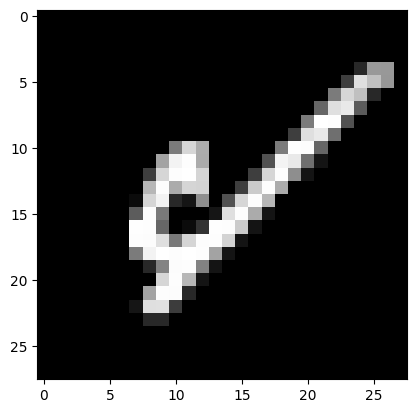

In [77]:
def visualize(model, dataset, idx=None):
    if idx is None:
        idx = random.randint(0, len(dataset))
    data, label = dataset[idx]
    plt.imshow(data.squeeze(), cmap="grey")
    pred = model(data)
    pred = torch.max(pred.data, 1).indices[0]
    print(f"Prediction: \t{pred}, label: \t{label}")

visualize(model, test_set)

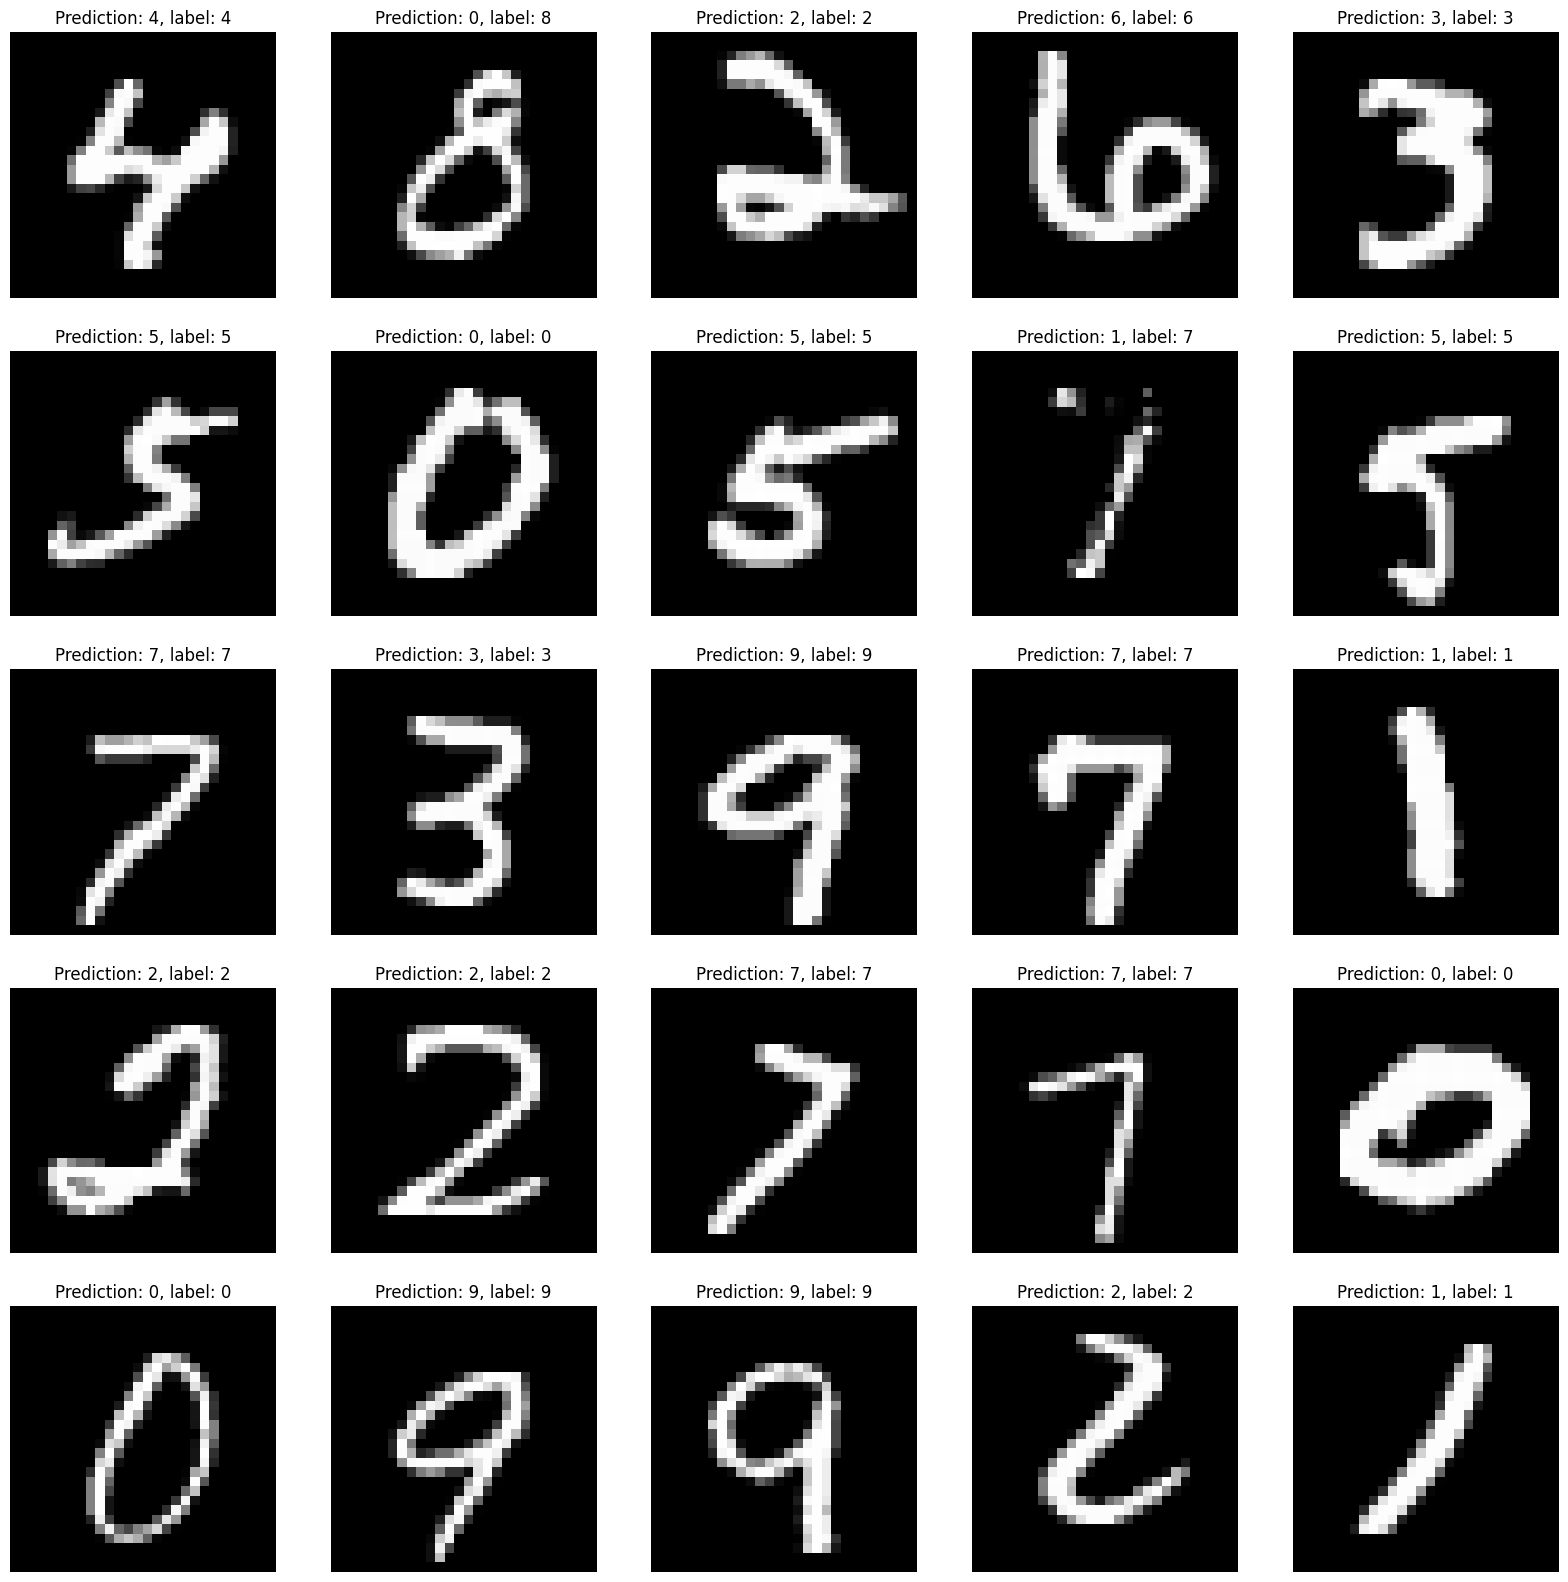

In [88]:
def show_marix(n_row, dataset):
    fig, axs = plt.subplots(n_row, n_row, figsize=(20,20))
    for i in range(n_row):
        for j in range(n_row):
            idx = random.randint(0, len(dataset))
            data, label = dataset[idx]
            pred = model(data)
            pred = torch.max(pred.data, 1).indices[0]
            axs[i][j].set_title(f"Prediction: {pred}, label: {label}")
            axs[i][j].imshow(data.squeeze(), cmap="grey")
            axs[i][j].axis("off")

show_marix(5, test_set)